## Análisis de componentes principales: PCA

### Librerías

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from collections import Counter
from math import sqrt
import seaborn as sns
from tqdm import tqdm

### Recolectar

In [2]:
df = pd.read_csv('heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


### Preparar

Observaciones

In [3]:
df['Diabetic'].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

In [4]:
df['AgeCategory'].unique()

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

Convertir las caracteristicas linguisticas a valores categoricos

In [5]:
datos = df.copy()
datos =  datos[datos.columns].replace({'Male':0, 'Female':1})
datos =  datos[datos.columns].replace({'Yes':1, 'No':0, 'No, borderline diabetes':2,'Yes (during pregnancy)':3 })
datos =  datos[datos.columns].replace({'American Indian/Alaskan Native':1, 'Asian':2, 'Black':3,'Hispanic':4, 'Other':5, 'White':6 })
encode_AgeCategory = {'55-59':57, '80 or older':80, '65-69':67,
                      '75-79':77,'40-44':42,'70-74':72,'60-64':62,
                      '50-54':52,'45-49':47,'18-24':21,'35-39':37,
                      '30-34':32,'25-29':27}
datos['AgeCategory'] = datos['AgeCategory'].apply(lambda x: encode_AgeCategory[x])
datos['AgeCategory'] = datos['AgeCategory'].astype('float')
datos =  datos[datos.columns].replace({'Excellent':4, 'Fair':1, 'Good':2,'Poor':0, 'Very good':3})

In [6]:
datos

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,1,57.0,6,1,1,3,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,1,80.0,6,0,1,3,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,0,67.0,6,1,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,1,77.0,6,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,1,42.0,6,0,1,3,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,0,62.0,4,1,0,1,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,0,37.0,4,0,1,3,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,1,47.0,4,0,1,2,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,1,27.0,4,0,0,2,12.0,0,0,0


In [7]:
datos.describe()[1:][['BMI','PhysicalHealth','MentalHealth', 'AgeCategory','SleepTime']].style.background_gradient(cmap='Blues')

,BMI,PhysicalHealth,MentalHealth,AgeCategory,SleepTime
mean,28.325399,3.371710,3.898366,54.355759,7.097075
std,6.356100,7.950850,7.955235,17.720429,1.436007
min,12.020000,0.000000,0.000000,21.000000,1.000000
25%,24.030000,0.000000,0.000000,42.000000,6.000000
50%,27.340000,0.000000,0.000000,57.000000,7.000000
75%,31.420000,2.000000,3.000000,67.000000,8.000000
max,94.850000,30.000000,30.000000,80.000000,24.000000


In [8]:
#Revisar datos nulos 
datos.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

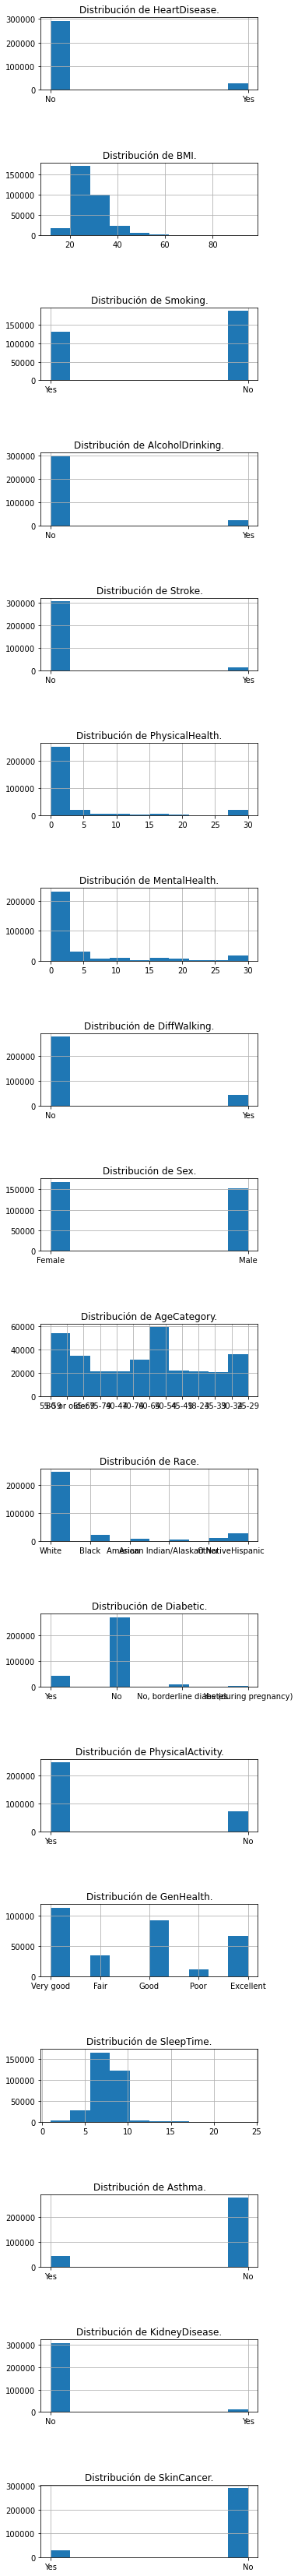

In [9]:
columnas = datos.columns.values
fig, axs = plt.subplots(df.shape[1], 1, figsize = (5,60))
plt.subplots_adjust(hspace = 1)
for i, c in enumerate(columnas):
  dist_datos = df[c]
  axs[i].set_title(f'Distribución de {c}.')
  axs[i].hist(dist_datos)
  axs[i].grid(True)

 
Min - max

In [10]:
def norm_min_max(datos):
  lim_sup = []
  lim_inf = []
  rangoDatos =[]
  maxNorm = 1
  minNorm = 0
  rango = maxNorm - minNorm
  for i in range (0,datos.columns.size):
    lim_sup.append(datos.iloc[:,i].max())
    lim_inf.append(datos.iloc[:,i].min())
    rangoDatos.append(lim_sup[i] - lim_inf[i])
  nombres = datos.columns.values.tolist()
  datosNorm = pd.DataFrame(columns = nombres)

  for j in range(len(datos.columns)):
    varNorm = []
    var = datos.iloc[:,j]
    for i in range(len(datos)):
      D = var[i] - lim_inf[j]
      DPct = D/rangoDatos[j]
      dNorm = rango*DPct
      varNorm.append(minNorm+dNorm)
    datosNorm.iloc[:,j] = varNorm
  datos = datosNorm
  return datos

In [11]:
datos = norm_min_max(datos)
datos

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0.0,0.055294,1.0,0.0,0.0,0.100000,1.0,0.0,1.0,0.610169,1.0,0.333333,1.0,0.75,0.173913,1.0,0.0,1.0
1,0.0,0.100447,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.000000,1.0,0.000000,1.0,0.75,0.260870,0.0,0.0,0.0
2,0.0,0.175782,1.0,0.0,0.0,0.666667,1.0,0.0,0.0,0.779661,1.0,0.333333,1.0,0.25,0.304348,1.0,0.0,0.0
3,0.0,0.147169,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.949153,1.0,0.000000,0.0,0.50,0.217391,0.0,0.0,1.0
4,0.0,0.141132,0.0,0.0,0.0,0.933333,0.0,1.0,1.0,0.355932,1.0,0.000000,1.0,0.75,0.304348,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1.0,0.185802,1.0,0.0,0.0,0.233333,0.0,1.0,0.0,0.694915,0.6,0.333333,0.0,0.25,0.217391,1.0,0.0,0.0
319791,0.0,0.215139,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.271186,0.6,0.000000,1.0,0.75,0.173913,1.0,0.0,0.0
319792,0.0,0.147531,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.440678,0.6,0.000000,1.0,0.50,0.217391,0.0,0.0,0.0
319793,0.0,0.250996,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.101695,0.6,0.000000,0.0,0.50,0.478261,0.0,0.0,0.0


### PCA  

Encontrar la matriz de covarianza y sus respectivos eigenvectores y eigenvalores 

In [12]:
def matriz_cov(data):
    atributos = data.columns 
    n = len(atributos)
    m = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X = data[atributos[i]]
            Y = data[atributos[j]]
            m[i][j] = (((X-X.mean())*(Y-Y.mean())).sum())/(len(X)-1)
    return m

In [13]:
datos1 = datos.drop(['HeartDisease'],axis=1) #Eliminando el atributo de decisión 
#Ajustar los datos restando la media a cada atributo
datos_A = pd.DataFrame(columns=datos1.columns,index=range(len(datos1)))
for i in datos_A.columns:
    datos_A[i] = datos1[i] - datos1[i].mean()    
datos_A

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,-0.141560,0.587523,-0.068097,-0.03774,-0.012390,0.870054,-0.13887,0.475273,0.044818,0.120652,0.268666,0.224638,0.101243,-0.091177,0.865939,-0.036833,0.906756
1,-0.096407,-0.412477,-0.068097,0.96226,-0.112390,-0.129946,-0.13887,0.475273,0.434648,0.120652,-0.064667,0.224638,0.101243,-0.004221,-0.134061,-0.036833,-0.093244
2,-0.021072,0.587523,-0.068097,-0.03774,0.554276,0.870054,-0.13887,-0.524727,0.214309,0.120652,0.268666,0.224638,-0.398757,0.039258,0.865939,-0.036833,-0.093244
3,-0.049685,-0.412477,-0.068097,-0.03774,-0.112390,-0.129946,-0.13887,0.475273,0.383801,0.120652,-0.064667,-0.775362,-0.148757,-0.047699,-0.134061,-0.036833,0.906756
4,-0.055721,-0.412477,-0.068097,-0.03774,0.820943,-0.129946,0.86113,0.475273,-0.209420,0.120652,-0.064667,0.224638,0.101243,0.039258,-0.134061,-0.036833,-0.093244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,-0.011052,0.587523,-0.068097,-0.03774,0.120943,-0.129946,0.86113,-0.524727,0.129563,-0.279348,0.268666,-0.775362,-0.398757,-0.047699,0.865939,-0.036833,-0.093244
319791,0.018286,0.587523,-0.068097,-0.03774,-0.112390,-0.129946,-0.13887,-0.524727,-0.294165,-0.279348,-0.064667,0.224638,0.101243,-0.091177,0.865939,-0.036833,-0.093244
319792,-0.049323,-0.412477,-0.068097,-0.03774,-0.112390,-0.129946,-0.13887,0.475273,-0.124674,-0.279348,-0.064667,0.224638,-0.148757,-0.047699,-0.134061,-0.036833,-0.093244
319793,0.054142,-0.412477,-0.068097,-0.03774,-0.112390,-0.129946,-0.13887,0.475273,-0.463657,-0.279348,-0.064667,-0.775362,-0.148757,0.213171,-0.134061,-0.036833,-0.093244


In [14]:
matrix = matriz_cov(datos_A)

<AxesSubplot:>

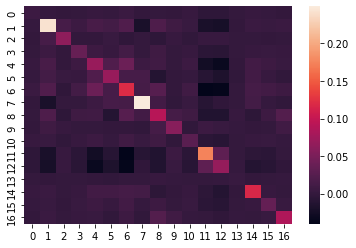

In [15]:
sns.heatmap(matrix)

In [16]:
L,V =  np.linalg.eig(matrix)

In [17]:
#Eigenvalores
L

array([0.28757052, 0.26486332, 0.19009429, 0.12647297, 0.12404555,
       0.09701111, 0.00529354, 0.00377293, 0.07360315, 0.06187594,
       0.05744162, 0.05385894, 0.0246463 , 0.04358201, 0.03576996,
       0.03378655, 0.0324242 ])

In [18]:
#Obtener el porcentaje de covarianza de cada uno de los atributos
total = L.sum()
p = (L/total)*100
columnas1 = datos_A.columns.values
for index, row in enumerate(p):
  print(columnas1[index] + ':',row)

BMI: 18.967619338273785
Smoking: 17.46989431225539
AlcoholDrinking: 12.538267815519589
Stroke: 8.341922886205536
PhysicalHealth: 8.181814868924253
MentalHealth: 6.398673105506228
DiffWalking: 0.34915183715675613
Sex: 0.2488557332486789
AgeCategory: 4.854727259823224
Race: 4.081222739746426
Diabetic: 3.7887428910156444
PhysicalActivity: 3.5524357409032428
GenHealth: 1.6256240537731756
SleepTime: 2.874588394650617
Asthma: 2.3593203249524075
KidneyDisease: 2.228498248851064
SkinCancer: 2.1386404491939914


PCA muesttra que los únicos atributos que aportan mayor información son 10 de 17 atributos: BMI,Smoking,AlcoholDrinking,Stroke, PhysicalHealth, MentalHealth,AgeCategory,Diabetic,PhysicalActivity, GenHealth, SleepTime sumando una ganancia por encima del 90%. (91.04%)

###  Datos de entrenamiento y prueba  

In [19]:
def method_8020(x,y):
  train_x = x[0 : int(len(x)*0.8)]
  train_y = y[0 : int(len(y)*0.8)]
  test_x = x[int(len(x)*0.8) : ]
  test_y = y[int(len(y)*0.8) : ]
  return train_x, train_y, test_x, test_y

In [57]:
y = datos['HeartDisease']
train_x, train_y, test_x, test_y = method_8020(datos,y)

In [58]:
train_x = train_x[:20000]
train_y = train_y[:20000]
test_x = test_x[:20000]
test_y = test_y[:20000]

#### Matriz de confusión y métricas de evaluación

In [59]:
#Función que obtiene las métricas del algoritmo para su validación
def metricas(claseP,true_train):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    #Determinar los TP,TN,FP y FN para la matriz de confusión del entrenamiento 
    for i in range(len(claseP)):
        if (true_train[i] == claseP[i]) and true_train[i] == 1:
            TP += 1
        elif (true_train[i] == claseP[i]) and true_train[i] == 0:
            TN += 1
        elif (true_train[i] != claseP[i]) and true_train[i] == 0:
            FP += 1
        else:
            FN += 1
            
    accuracy = ((TP+TN)/(TP+TN+FP+FN))
   
    if TP + FP != 0:
        precision = TP/(TP+FP)
    else:
        precision = 0
    if TP + FN != 0:
        sensitividad = TP/(TP+FN)
    else:
        sensitividad = 0
    if precision != 0 and sensitividad != 0:
        f1 = (2*TP)/(2*TP+FP+FN)
    else:
        f1 = 0
    return [accuracy, precision, sensitividad, f1]

In [60]:
# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0 
	for i in range(len(row1)-1):										#for k in range(23)
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

In [61]:
def get_neighbors(k,distances_ord):
  neighbors = list()
  indices = list()
  for i in range(k):
    neighbors.append(distances_ord[i][0])
    indices.append(distances_ord[i][1])
  return neighbors,indices

In [62]:
def most_common(output_values):
    return max(set(output_values), key=output_values.count)

In [63]:
#entrenamiento del modelo
def predict_classification(x,y, k):
    predict = []
    for j in tqdm(range(0,len(x))):
        # Inicializacion de las distancias.
        distances = []
        x = np.array(x)
        for i ,example in enumerate(x):
            distance = euclidean_distance(example,x[j])# Calculate the Euclidean distance between two vectors
            distances.append((distance, i))
        distances.pop(j)
        distances_ord = sorted(distances)
        neighbors,indices = get_neighbors(k,distances_ord)
        output_values = y.iloc[indices]
        output_values = output_values.to_numpy().tolist()
        predict.append(most_common(output_values))
    return predict

### Clasificación de sobrevivientes utilizando todos los atributos

In [64]:
error_rate = []

n = int(len(train_x)/20)
for k in range(2,10):
    pred_i = predict_classification(train_x.values.tolist(),train_y,k) 
    #print(pred_i)
    error_rate.append(np.mean(pred_i != train_y))

100%|██████████| 20000/20000 [46:19<00:00,  7.20it/s]


Text(0, 0.5, 'Error Rate')

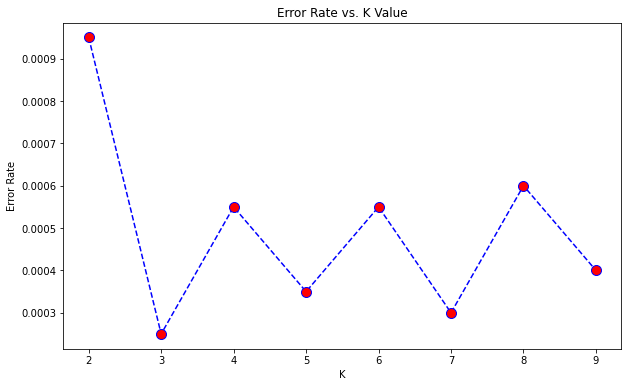

In [65]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),error_rate,color='blue', linestyle='dashed', marker='o',
markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

##### Entrenamiento 

In [66]:
inicio = time.time()
train_pred = predict_classification(train_x.values.tolist(),train_y,3)
final = time.time()
print('Tiempo de entrenamiento:' + str(final-inicio))

100%|██████████| 20000/20000 [45:58<00:00,  7.25it/s]

Tiempo de entrenamiento:2758.8218455314636


In [67]:
accuracy, precision, sensitividad, f1 = metricas(train_pred,np.array(train_y))

print('Exactitud: ',accuracy)
print('Precisión: ',precision)
print('Sensitividad: ',sensitividad)
print('f1 Score: ',f1)

Exactitud:  0.99975
Precisión:  1.0
Sensitividad:  0.9975320829220138
f1 Score:  0.9987645169261181


#### Prueba del algoritmo 

In [68]:
y_pred= predict_classification(test_x.values.tolist(),test_y,3)

100%|██████████| 20000/20000 [48:46<00:00,  6.83it/s]


In [69]:
accuracy, precision, sensitividad, f1 = metricas(y_pred,np.array(test_y))

print('Exactitud: ',accuracy)
print('Precisión: ',precision)
print('Sensitividad: ',sensitividad)
print('f1 Score: ',f1)

Exactitud:  0.99975
Precisión:  1.0
Sensitividad:  0.9969173859432799
f1 Score:  0.9984563136770608


### Clasificación de HeartDisease PCA

In [70]:
error_rate = []

n = int(len(train_x)/20)
for k in range(2,10):
    pred_i = predict_classification(train_x.loc[:,['BMI','Smoking','AlcoholDrinking','Stroke','PhysicalHealth','MentalHealth','AgeCategory','Diabetic','GenHealth','PhysicalActivity','SleepTime']].values.tolist(),train_y,k) #checar función
    error_rate.append(np.mean(pred_i != train_y))

100%|██████████| 20000/20000 [31:28<00:00, 10.59it/s]


Text(0, 0.5, 'Error Rate')

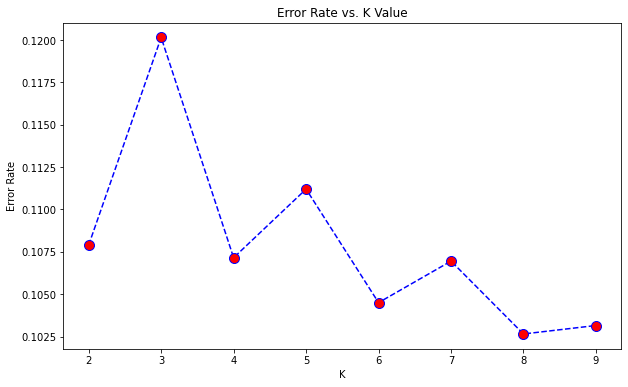

In [71]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),error_rate,color='blue', linestyle='dashed', marker='o',
markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

#### Entrenamiento

In [75]:
x = train_x.loc[:,['BMI','Smoking','AlcoholDrinking','Stroke','PhysicalHealth','MentalHealth','AgeCategory','Diabetic','GenHealth','PhysicalActivity','SleepTime']].values.tolist()
inicio = time.time()
train_pred_pca = predict_classification(x,train_y,6)
final = time.time()
print('Tiempo de entrenamiento:' + str(final-inicio))

100%|██████████| 20000/20000 [30:01<00:00, 11.10it/s]

Tiempo de entrenamiento:1801.4729025363922


In [76]:
accuracy, precision, sensitividad, f1 = metricas(train_pred_pca,np.array(train_y))

print('Exactitud: ',accuracy)
print('Precisión: ',precision)
print('Sensitividad: ',sensitividad)
print('f1 Score: ',f1)

Exactitud:  0.8955
Precisión:  0.4282511210762332
Sensitividad:  0.09427443237907206
f1 Score:  0.15453074433656958


#### Testing 

In [77]:
test_y_pred_pca= predict_classification(test_x.loc[:,['BMI','Smoking','AlcoholDrinking','Stroke','PhysicalHealth','MentalHealth','AgeCategory','Diabetic','GenHealth','PhysicalActivity','SleepTime']],test_y,6)

100%|██████████| 20000/20000 [30:13<00:00, 11.03it/s]


In [78]:
accuracy, precision, sensitividad, f1 = metricas(test_y_pred_pca,np.array(test_y))

print('Exactitud: ',accuracy)
print('Precisión: ',precision)
print('Sensitividad: ',sensitividad)
print('f1 Score: ',f1)

Exactitud:  0.9186
Precisión:  0.4911242603550296
Sensitividad:  0.10234278668310727
f1 Score:  0.16938775510204082
